psnrs_array: [51.781605636586406, 51.80514274778449, 51.785539517673584, 51.77018183827912, 51.7748191328084, 51.786493722685584, 51.78029513434734, 51.80059265354078, 51.80071233180853, 51.80035330689873, 51.786732306700316, 51.763887800305994, 51.80969761415263, 51.793179034483344, 51.80442399484761, 51.767686882973805, 51.8016698766959, 51.783512527865796, 51.80442399484761, 51.802747367111515, 51.790909650029356, 51.80047297857091, 51.80694015071786, 51.783035726545776, 51.80238817393585, 51.795808225153046, 51.76626183749253, 51.772797139209956, 51.8245941781634, 51.76270126819134, 51.78243979849909, 51.73526433359555, 51.74151699546769, 51.761989504493656, 51.76163366638404, 51.71562121568061, 51.74943420881264, 51.78732882408592, 51.7866130130546, 51.791626169648055, 51.803825124920294, 51.798678249644325, 51.78005690369347, 51.77517605295208, 51.785658781835366, 51.782797345514396, 51.79592777164737, 51.75345742646854, 51.8211057239547, 51.81425726266572, 51.82038432452019, 51.

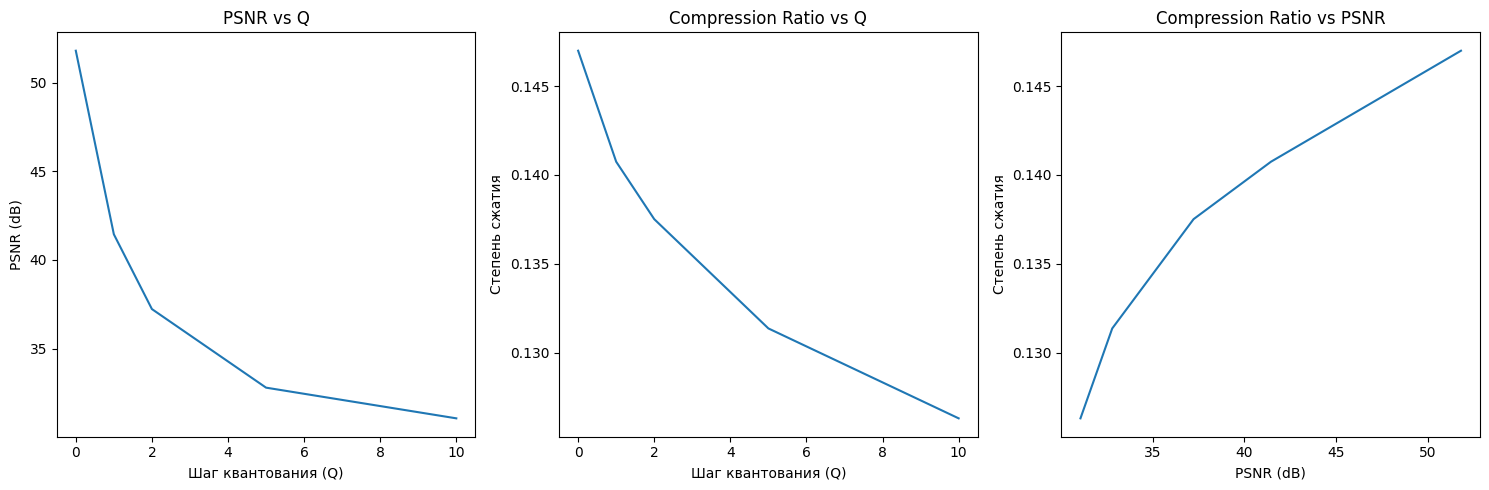

In [11]:
import av
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from scipy.fftpack import dct, idct
import math
from collections import Counter
import numba
import os


def dct2d(block: np.ndarray) -> np.ndarray:
    """
    Двумерное ДКП
    """
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

def idct2d(block: np.ndarray) -> np.ndarray:
    """
    Обратное двумерное ДКП
    """
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

@numba.jit(nopython=True)
def calc_Q_block(size_block: int, Rquant: int):
        Q_matrix = np.zeros((size_block, size_block))
        for i in range(0, size_block):
            for j in range(0, size_block):
                Q_matrix[i][j] = 1 + (i + j) * Rquant
        return Q_matrix

@numba.jit(nopython=True)
def quantize(block: np.ndarray, Rquant: int, size_block: int = 8):
    Q_block = calc_Q_block(size_block, Rquant)
    res = np.zeros((size_block, size_block))
    for i in range(0, size_block):
        for j in range(0, size_block):
            res[i][j] = round(block[i][j] / Q_block[i][j])
    return res

@numba.jit(nopython=True)
def dequantize(block: np.ndarray, Rquant: int, size_block: int = 8):
    Q_block = calc_Q_block(size_block, Rquant)
    res = np.zeros((size_block, size_block))
    for i in range(0, size_block):
        for j in range(0, size_block):
            res[i][j] = block[i][j] * Q_block[i][j]
    return res
    
    
# def quantize(block: np.ndarray, q_step: int) -> np.ndarray:
#     """
#     Квантование ДКП коэффициентов
#     """
#     return np.round(block / q_step)

# def dequantize(block: np.ndarray, q_step: int) -> np.ndarray:
#     """
#     Деквантование ДКП коэффициентов
#     """
#     return block * q_step

@numba.jit(nopython=True)
def logarithmic_search(curr_block: np.ndarray, 
                    reference_frame: np.ndarray, 
                    x: int, 
                    y: int, 
                    search_radius: int = 8) -> Tuple[int, int]:
    """
    Реализация алгоритма логарифмического поиска для оценки движения
    """
    block_size = curr_block.shape[0]
    best_x, best_y = x, y
    best_sad = float('inf')
    step = search_radius // 2

    while step >= 1:
        for dx in [-step, 0, step]:
            for dy in [-step, 0, step]:
                new_x = x + dx
                new_y = y + dy
                
                if (new_x < 0 or new_x + block_size > reference_frame.shape[0] or
                    new_y < 0 or new_y + block_size > reference_frame.shape[1]):
                    continue
                
                reference_block = reference_frame[new_x:new_x+block_size, 
                                            new_y:new_y+block_size]
                
                sad = np.sum(np.abs(curr_block - reference_block))
                
                if sad < best_sad:
                    best_sad = sad
                    best_x = new_x
                    best_y = new_y
        
        step //= 2
    
    return best_x - x, best_y - y

def compute_motion_compensated_frame(current: np.ndarray, 
                                reference: np.ndarray,
                                block_size: int = 8,
                                search_radius: int = 8,
                                Rquant: int = 1) -> Tuple[np.ndarray, np.ndarray, np.ndarray, int]:
    """
    Вычисление разностного кадра с компенсацией движения и его обработка
    """
    height, width = current.shape
    # motion_vectors = np.zeros((height // block_size, width // block_size, 2), dtype=np.int8)
    diff_frame = np.zeros_like(current, dtype=np.int64)
    # predicted_frame = np.zeros_like(current, dtype=np.uint8)
    reconstructed_frame = np.zeros_like(current, dtype=np.uint8)
    
    compressed_size = 0
    bits_per_coefficient = 8  # пример
    bits_per_motion_vector_component = 8 # пример
    
    for i in range(0, height - block_size + 1, block_size):
        for j in range(0, width - block_size + 1, block_size):
            curr_block = current[i:i+block_size, j:j+block_size]
            
            # Оценка движения
            dx, dy = logarithmic_search(curr_block, reference, i, j, search_radius=search_radius)
            # motion_vectors[i // block_size, j // block_size] = [dx, dy]
            
            # Компенсация движения
            reference_block = reference[i+dx:i+dx+block_size, j+dy:j+dy+block_size]
            # predicted_frame[i:i+block_size, j:j+block_size] = reference_block
            
            # Вычисление разностного блока
            diff_block = curr_block.astype(np.int64) - reference_block.astype(np.int64)

            # ДКП разностного блока
            dct_diff_block = dct2d(diff_block)

            # Квантование ДКП коэффициентов разностного блока
            quantized_dct_diff = quantize(dct_diff_block, Rquant, block_size)

            # Деквантование
            dequantized_dct_diff = dequantize(quantized_dct_diff, Rquant, block_size)

            # Обратное ДКП 
            reconstructed_diff = idct2d(dequantized_dct_diff)


            # Сохранение разностного блока (ДЛЯ ДЕБАГА)
            diff_frame[i:i+block_size, j:j+block_size] = diff_block
            
            # Восстановление блока
            reconstructed_block = np.clip(reference_block.astype(np.int64) + 
                                    reconstructed_diff, 0, 255).astype(np.uint8)
            reconstructed_frame[i:i+block_size, j:j+block_size] = reconstructed_block
            
            # Оценка размера
            compressed_size += quantized_dct_diff.size * bits_per_coefficient
            compressed_size += 2 * bits_per_motion_vector_component
            
    return diff_frame, reconstructed_frame, compressed_size

def calculate_entropy(data: np.ndarray) -> float:
    """
    Вычисление энтропии для массива данных
    """
    # Подсчет частот значений
    counter = Counter(data.flatten())
    total = len(data.flatten())
    
    # Вычисление энтропии
    entropy = 0
    for count in counter.values():
        probability = count / total
        entropy -= probability * math.log2(probability)
    return entropy

def calculate_bits_for_frame(dct_coeffs: np.ndarray, motion_vectors: np.ndarray) -> Tuple[float, float]:
    """
    Вычисление количества бит для кодирования кадра по формуле из документации
    """
    # Расчет Bits1 (для разностного кадра)
    N_DC = np.sum(dct_coeffs != 0)  # Количество ненулевых DC коэффициентов
    BC_dDC = dct_coeffs[dct_coeffs != 0]  # Значения DC коэффициентов
    
    # Вычисление Run/Level пар
    runs = []
    levels = []
    for coeff in dct_coeffs.flatten():
        if coeff != 0:
            levels.append(coeff)
            runs.append(len(runs))
    
    # Расчет компонентов формулы Bits1
    entropy_BC_dDC = calculate_entropy(BC_dDC) if len(BC_dDC) > 0 else 0
    sum_BC_dDC = np.sum(np.abs(BC_dDC)) if len(BC_dDC) > 0 else 0
    entropy_run_level = calculate_entropy(np.array(runs)) if runs else 0
    sum_BC_level = np.sum(np.abs(levels)) if levels else 0
    
    Bits1 = (entropy_BC_dDC * N_DC + 
            sum_BC_dDC + 
            entropy_run_level * len(runs) + 
            sum_BC_level)
    
    # Расчет Bits2 (для векторов движения)
    N_MV = motion_vectors.shape[0] * motion_vectors.shape[1]  # Количество макроблоков
    entropy_MV = calculate_entropy(motion_vectors)
    
    Bits2 = entropy_MV * N_MV
    
    return Bits1, Bits2

def process_video(input_path: str, output_diff_path: str, output_recon_path: str, 
                Rquant: int = 1) -> Tuple[float, float]:
    """
    Обработка видео с сохранением разностных и восстановленных кадров
    """
    container = av.open(input_path)
    diff_container = av.open(output_diff_path, mode='w')
    recon_container = av.open(output_recon_path, mode='w')
    
    # Настройка выходных потоков
    diff_stream = diff_container.add_stream('mpeg4', 
                                        rate=container.streams.video[0].codec_context.rate)
    recon_stream = recon_container.add_stream('mpeg4',
                                            rate=container.streams.video[0].codec_context.rate)
    
    for stream in [diff_stream, recon_stream]:
        stream.width = container.streams.video[0].width
        stream.height = container.streams.video[0].height
        stream.pix_fmt = 'yuv420p'
    
    original_frames = []
    reconstructed_frames = []
    previous_frame = None
    total_original_size = 0
    total_bits_original = 0
    total_bits_compressed = 0
    total_compressed_size = 0
    frame_count = 0
    
    
    for frame in container.decode(video=0):
        # Извлечение компоненты Y
        frame_count += 1
        img = frame.to_ndarray(format='yuv420p')
        y_component = img[:diff_stream.height, :diff_stream.width].astype(np.uint8)
        
        W = diff_stream.width
        H = diff_stream.height
        total_bits_original += W * H * 8
        
        if previous_frame is None:
            # Первый кадр сохраняем без изменений
            diff_frame = np.zeros_like(y_component)
            reconstructed_frame = y_component.copy()
            compressed_size = y_component.size
            motion_vectors = np.zeros((H // 8, W // 8, 2), dtype=np.int8)
            dct_coeffs = dct2d(diff_frame.astype(np.float64))
        else:
            # Для остальных кадров применяем компенсацию движения и ДКП
            diff_frame, reconstructed_frame, compressed_size = compute_motion_compensated_frame(
                y_component, previous_frame, Rquant=Rquant)
            dct_coeffs = dct2d(diff_frame.astype(np.float64))
        
        total_compressed_size += compressed_size
        # Клипирование разностного кадра для визуализации
        diff_frame_vis = np.clip(diff_frame + 128, 0, 255).astype(np.uint8)
        
        # Сохранение разностного кадра
        diff_out_frame = av.VideoFrame.from_ndarray(diff_frame_vis, format='gray')
        packet = diff_stream.encode(diff_out_frame)
        diff_container.mux(packet)
        
        # Сохранение восстановленного кадра
        recon_out_frame = av.VideoFrame.from_ndarray(reconstructed_frame, format='gray')
        packet = recon_stream.encode(recon_out_frame)
        recon_container.mux(packet)
        
        bits1, bits2 = calculate_bits_for_frame(dct_coeffs, motion_vectors)
        total_bits_compressed += bits1 + bits2
        
        original_frames.append(y_component)  # Сохраняем оригинальный кадр
        reconstructed_frames.append(reconstructed_frame)  # Сохраняем восстановленный кадр
        previous_frame = reconstructed_frame  # Используем восстановленный кадр как опорный
        
        total_original_size += y_component.size
        total_compressed_size += reconstructed_frame.size
    
    # Очистка буферов энкодеров
    for stream, container in [(diff_stream, diff_container), 
                            (recon_stream, recon_container)]:
        for packet in stream.encode():
            container.mux(packet)
        container.close()
    
    container.close()
    
    # Вычисление метрик
    # PSNR между оригинальными и восстановленными кадрами
    psnrs_array = [calculate_psnr(original_frames[i], reconstructed_frames[i]) 
                        for i in range(len(original_frames))][1:]
    print(f"psnrs_array: {psnrs_array}")
    avg_psnr = np.mean(psnrs_array)
    # compression_ratio = total_original_size / total_compressed_size
    compression_ratio = (frame_count * W * H * 8) / total_bits_compressed
    
    return avg_psnr, compression_ratio


def calculate_psnr(original_frame: np.ndarray, recovered_frame: np.ndarray) -> float:
    """
    Calculate the PSNR for a single original and recovered frame.

    :param original_frame: Original frame (np.ndarray).
    :param recovered_frame: Recovered frame (np.ndarray).
    :return: PSNR value for the frame.
    """
    if original_frame.shape != recovered_frame.shape:
        raise ValueError("Original and recovered frames must have the same dimensions.")
    
    # Calculate Mean Squared Error (MSE)
    mse = np.mean((original_frame - recovered_frame) ** 2)
    
    # Avoid division by zero
    if mse == 0:
        return float('inf')
    
    # Calculate PSNR
    max_pixel = 255.0  # Assuming 8-bit images
    psnr = 10 * math.log10((max_pixel ** 2) / mse)
    
    return psnr

def plot_metrics(q_steps: List[int], 
                psnr_values: List[float], 
                compression_ratios: List[float]):
    """
    Построение графиков метрик
    """
    plt.figure(figsize=(15, 5))
    
    plt.subplot(131)
    plt.plot(q_steps, psnr_values)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('PSNR (dB)')
    plt.title('PSNR vs Q')
    
    plt.subplot(132)
    plt.plot(q_steps, compression_ratios)
    plt.xlabel('Шаг квантования (Q)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs Q')
    
    plt.subplot(133)
    plt.plot(psnr_values, compression_ratios)
    plt.xlabel('PSNR (dB)')
    plt.ylabel('Степень сжатия')
    plt.title('Compression Ratio vs PSNR')
    
    plt.tight_layout()
    plt.show()

def main():
    diff_folder = "output/diff"
    recon_folder = "output/recon"
    input_path = 'lr1_1.avi'
    # q_steps = [1, 2, 4, 8, 16, 32]
    # Rquant_steps = [1, 2, 5, 10]
    Rquant_steps = [0, 1, 2, 5 , 10]
    psnr_values = []
    compression_ratios = []
    
    for Rquant in Rquant_steps:
        diff_path = os.path.join(diff_folder, f"diff_q{Rquant}.avi")
        recon_path = os.path.join(recon_folder, f"recon_q{Rquant}.avi")    
        
        psnr, ratio = process_video(
            input_path, 
            diff_path,
            recon_path,
            Rquant,
        )
        psnr_values.append(psnr)
        compression_ratios.append(ratio)
    print(f"PSNR: {psnr_values}")
    print(f"Compression ratios: {compression_ratios}")
    plot_metrics(Rquant_steps, psnr_values, compression_ratios)

if __name__ == '__main__':
    main()